In [2]:
import OffsetArrays
using Plots
using Revise
using StatsBase
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using Distributions
srcpath = "../src"

"../src"

In [3]:
include("$srcpath/single_instance.jl")
T = 8
Ngraph = 40000 # size of the single instance graph
N = Ngraph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory
degree_dist = Dirac(3)
G = makeGraph(Ngraph,degree_dist)
γRange = LinRange(0.001,0.025,100) 
nconn = zeros(100)
λp = 1.0
@showprogress for st = 1:100
    sample!(x, G, λp, γRange[st])
    nconn[st] = S_subgraph(G,x)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


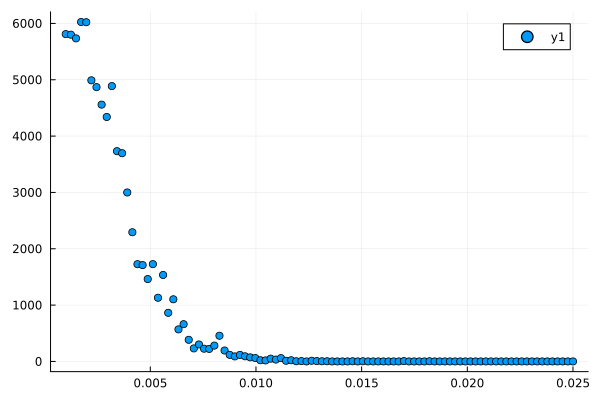

In [4]:
scatter(γRange,nconn)

In [11]:
T = 8
Ngraph = 1000000 # size of the single instance graph
N = Ngraph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory
degree_dist = Dirac(3)
G = makeGraph(Ngraph,degree_dist)
γRange = LinRange(0.001,0.025,100) 
n_zp = zeros(100)
@showprogress for st = 1:100
    sample!(x, G, λp, γRange[st])
    n_zp[st] = possible_zero_patients(G,x)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


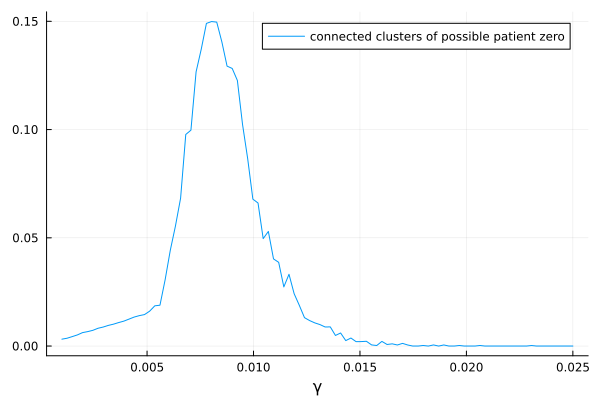

In [12]:
plot(γRange,n_zp ./ N,xlabel="γ",label="connected clusters of possible patient zero")